## week01: Intro, Linear models recap, simple ensembles.

## Часть 1. Работа с моделями и ансамблями моделей в задачи классификации.

### 1. Чтение данных.
Воспользуемся [датасетом](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), в котором описываются различные автомобили. Будем решать задачу многоклассовой ($k=4$) классификации.
Для удобства, датасет уже преобразован в удобный формат.

In [1]:
# ! pip install scikit-plot
# ! pip install joblib

In [2]:
from collections import defaultdict
from joblib import Parallel, delayed

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import scikitplot
from sklearn.metrics import accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.exceptions import DataConversionWarning

from tqdm import tqdm_notebook
import warnings

%matplotlib inline

In [17]:
dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

print(data.shape, target.shape)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35, random_state=57)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(846, 19) (846,)
(549, 19) (549,) (297, 19) (297,)


Для первичного анализа может быть полезна библиотека `pandas`. Преобразуем `train` выборку в `pd.DataFrame`.

In [18]:
X_train_pd = pd.DataFrame(X_train)

# First 15 rows of our dataset.
X_train_pd.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,233,100,52,104,189,59,10,208,32,24,163,220,642,197,70,1,22,187,198
1,546,92,40,66,111,48,7,139,50,19,140,159,277,148,85,12,19,182,183
2,383,100,51,109,224,67,9,217,30,24,162,238,704,206,72,6,18,189,199
3,609,87,42,60,116,51,6,150,46,19,141,169,324,171,85,2,14,178,182
4,543,96,37,74,187,68,8,159,42,20,134,183,378,134,69,3,16,190,197
5,232,81,44,68,120,53,6,151,45,19,147,170,333,178,86,4,5,179,183
6,366,90,47,85,149,60,10,155,43,19,155,179,355,186,75,1,5,185,196
7,741,87,39,74,165,66,6,145,45,19,134,173,318,139,70,3,21,195,200
8,809,79,38,55,120,55,5,142,48,19,128,153,295,145,81,4,2,180,183
9,226,107,54,98,210,66,11,218,31,24,169,221,704,216,71,14,0,188,197


Воспользовавшись методами `describe` и `info` можно получить полезную информацию о датасете.

In [19]:
X_train_pd.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,429.016393,93.754098,44.872495,81.876138,167.245902,61.242259,8.360656,168.814208,41.007286,20.599271,148.173042,188.178506,440.296903,174.759563,72.673953,6.437158,12.324226,188.721311,195.333333
std,244.325187,8.330075,6.223202,16.135239,32.740291,7.043760,3.712425,33.873289,7.980127,2.644316,14.696477,32.047652,180.179111,33.101047,7.391137,4.944045,8.595990,6.273621,7.518833
min,0.000000,73.000000,33.000000,40.000000,105.000000,47.000000,3.000000,112.000000,26.000000,17.000000,119.000000,130.000000,184.000000,109.000000,59.000000,0.000000,0.000000,176.000000,181.000000
25%,223.000000,87.000000,39.000000,70.000000,139.000000,57.000000,6.000000,146.000000,33.000000,19.000000,137.000000,167.000000,317.000000,147.000000,68.000000,2.000000,5.000000,184.000000,190.000000
50%,432.000000,93.000000,44.000000,79.000000,166.000000,61.000000,8.000000,157.000000,43.000000,20.000000,146.000000,178.000000,364.000000,174.000000,72.000000,6.000000,11.000000,188.000000,196.000000
75%,641.000000,100.000000,50.000000,98.000000,195.000000,65.000000,10.000000,200.000000,46.000000,23.000000,160.000000,217.000000,600.000000,199.000000,76.000000,10.000000,18.000000,193.000000,201.000000
max,845.000000,117.000000,59.000000,112.000000,333.000000,138.000000,52.000000,265.000000,61.000000,29.000000,188.000000,320.000000,1018.000000,268.000000,135.000000,22.000000,38.000000,206.000000,211.000000


In [20]:
X_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       549 non-null    int64
 1   1       549 non-null    int64
 2   2       549 non-null    int64
 3   3       549 non-null    int64
 4   4       549 non-null    int64
 5   5       549 non-null    int64
 6   6       549 non-null    int64
 7   7       549 non-null    int64
 8   8       549 non-null    int64
 9   9       549 non-null    int64
 10  10      549 non-null    int64
 11  11      549 non-null    int64
 12  12      549 non-null    int64
 13  13      549 non-null    int64
 14  14      549 non-null    int64
 15  15      549 non-null    int64
 16  16      549 non-null    int64
 17  17      549 non-null    int64
 18  18      549 non-null    int64
dtypes: int64(19)
memory usage: 81.6 KB


In [21]:
# Рассмотрим значения целевой переменной
np.unique(target)

array(['bus', 'opel', 'saab', 'van'], dtype=object)

### 2. Работа с данными, построение модели, анализ ошибки.
Выполним основные манипуляции с данными:

#### 2.0. Предобработка данных.
* Какие манипуляции с данными необходимы по вашему мнению?

In [22]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Например, в датасете присутствуют категориальные признаки, различные признаки в различных шкалах и пр.

prepr = StandardScaler()

#### 2.1. Базовая логистическая регрессия.
* Подберем оптимальные параметры логистической регресии с помощью кросс-валидации на train-датасете. Небольшого grid/random search'а хватит.

* Построим график ROC-кривой для данного классификатора и оценим точность классификации и f1-score. 

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline


pipeline = make_pipeline(
    prepr,
    LogisticRegression(),
)

In [33]:
lr_cv = GridSearchCV(
    pipeline,
    {'logisticregression__C': np.exp(np.linspace(-3, 3, 5))}
)
lr_cv.fit(X_train, y_train)

/usr/local/Caskroom/miniconda/base/envs/ml-mipt/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/Caskroom/miniconda/base/envs/ml-mipt/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([ 0.04978707,  0.22313016,  1.        ,  4.48168907, 20.08553692])})

In [34]:
print("Accuracy score: ", lr_cv.best_score_)

Accuracy score:  0.8014512093411177


In [35]:
print("Best model params: ", lr_cv.best_estimator_)

Best model params:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=20.085536923187668))])


Пакет `scikitplot` позволяет строить красивые `ROC`-кривые (и по-умолчанию удобнее, чем `sklearn.metrics.roc_curve`).

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

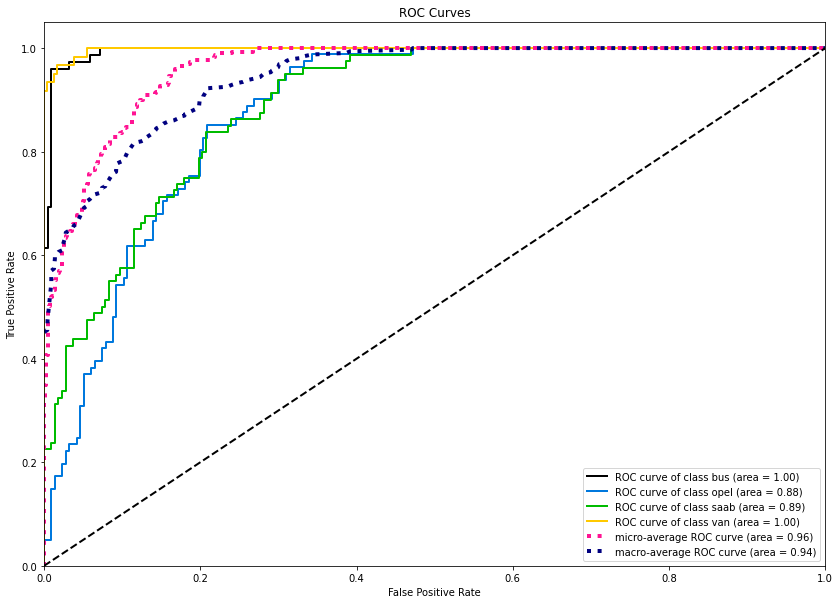

In [36]:
scikitplot.metrics.plot_roc(y_test, lr_cv.predict_proba(X_test), 
                            figsize=(14, 10))
        

# def plot_roc_auc_curve_multiclass(y_true, y_pred, y_pred_proba, suptitle):
#     sns.set(style="whitegrid", font_scale=1.3)
#     print("- accuracy: {:.3f}\n- f1: {:.3f}".format(
#         accuracy_score(y_test, y_pred),
#         f1_score(y_test, y_pred, average="weighted")
#     ))

# plot_roc_auc_curve_multiclass(y_test, 
#                               lr_cv.predict(X_test), 
#                               lr_cv.predict_proba(X_test), 
#                               "Logistic Regression")

#### 2.2. Зависимость объясненной дисперсии от числа главных компонент.
Воспользуемся методом главных компонент (PCA). 

Применим его к train-части данных.
Затем построим график зависимости объясненной дисперсии (explained variance ratio) от количества главных компонент.

In [38]:
X_train.shape

(549, 19)

In [37]:
from sklearn.decomposition import PCA

pca = PCA()

In [ ]:
X_pca = pca.fit_transform(X_train)

In [51]:
pca_pipe = make_pipeline(StandardScaler(), PCA())

In [52]:
pca_pipe.fit(X_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

In [43]:
X_pca.shape

(549, 19)

In [44]:
pca.explained_variance_ratio_

array([6.18871811e-01, 3.66454908e-01, 6.60304470e-03, 4.24431357e-03,
       1.33212917e-03, 7.10706453e-04, 4.96578961e-04, 3.86388517e-04,
       3.02358678e-04, 2.36663345e-04, 1.22071425e-04, 8.59080996e-05,
       6.01641840e-05, 4.03910263e-05, 2.57620678e-05, 1.64243659e-05,
       7.08570185e-06, 2.56626406e-06, 7.24323775e-07])

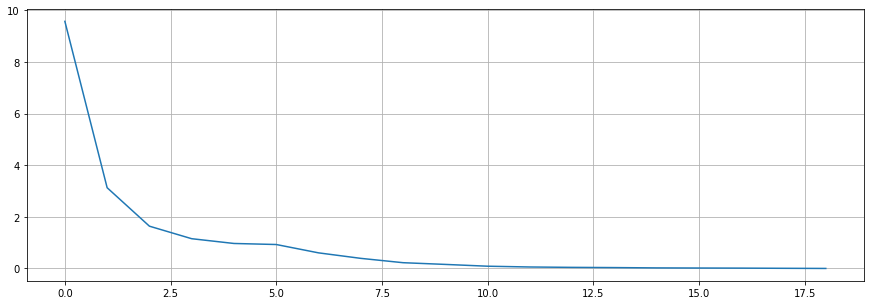

In [56]:
plt.figure(figsize=(15, 5))
plt.plot(pca_pipe['pca'].explained_variance_)
plt.grid()

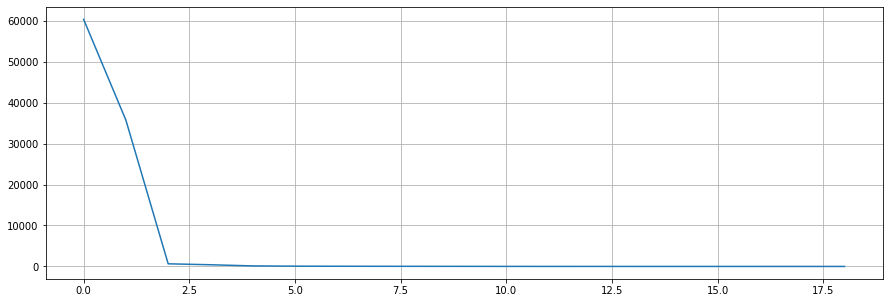

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(pca.explained_variance_)
plt.grid()

#### 2.3. Преобразование с помощью PCA.
Выберем оптимальное число компонент. Чем должен быть обусловлен наш выбор?

Используя эти главные компоненты, преобразуем train и test выборки (используя методы `fit` и `transform`).

In [ ]:
pca = PCA(n_components=<N BEST COMPONENTS>)

X_train_proj = # YOUR CODE HERE pca.fit_transform(X_train)
X_test_proj = # YOUR CODE HEREpca.transform(X_test)

#### 2.4. Логистическая регрессия над преобразованными данными.
* Подберем оптимальные параметры логистической регресии с помощью кросс-валидации на преобразованном train-датасете.

* Снова построим график ROC-кривой для полученных классификаторов, оценим точность классификации и f1-score. 

In [67]:
pca_lr_pipe = make_pipeline(StandardScaler(), PCA(9), LogisticRegression(max_iter=1000))
pca_cv = GridSearchCV(
    pca_lr_pipe,
    {'logisticregression__C': np.exp(np.linspace(-3, 3, 5))}
)
pca_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=9)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': array([ 0.04978707,  0.22313016,  1.        ,  4.48168907, 20.08553692])})

In [68]:
print("Accuracy score: ", pca_cv.best_score_)

Accuracy score:  0.6666388657214345


#### 2.5. Решающее дерево.
Рассмотрим поведение решающего дерева на исходных и преобразованных данных. Будем варьировать лишь один параметр - максимальную глубину дерева. 

* С помощью кросс-валидации подберем оптимальный параметр `max_depth` и оцените на исходных и преобразованных данных те же метрики, что и выше.

In [ ]:
from sklearn.tree import DecisionTreeClassifier



In [ ]:
print(accuracy_score(dt_cv.predict(X_train), y_train))

Судя по `accuracy` на обучающей выборке, дерево могло переобучиться. Рассмотрим данные после применения PCA.

In [ ]:
# YOUR CODE HERE

#### 2.6. Bagging.
Перейдем к ансамблям. 

Для построения ансамбля воспользуемся Bagging'ом с числом алгоритмов от 2 до 50. В качестве первого семейства базовых алгоримтов будем использовать линейные модели (т.е. логистическую регрессию), в качестве второго - решающие деревья. 

*Пояснение: Будем строить ансамбль только из моделей из одного семейства, т.е. логистическая регрессия не смешивается с решающими деревьями.*

Для этого можно сгенерировать с помощью метода bootstrap 50 подвыборок из `train` выборки (того же размера, что и исходная), обучить логистическую регрессию и решающее дерево с оптимальными параметрами из предыдущего пункта на каждой из подвыборок и затем усреднить предсказания k моделей.

*Hint: в sklearn может найтись подходящая функция, которая облегчит вам реализацию данного пункта.*

* Построим график качества классификации и f1-score на `train` и `test` датасетах в зависимости от числа алгоритмов, вошедших в ансамбль.

* Проанализируем график. Какое количество моделей стоит использовать? Как вы думаете, являются ли параметры решающего дерева, подобранные в предыдущем пункте оптимальными в данном случае?

In [ ]:
from sklearn.ensemble import BaggingClassifier

# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

А теперь построим ансамбль решающих деревьев.

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

#### 2.7. Random Forest.
Теперь воспользуемся `sklearn`-реализацией алгоритма Random Forest. 

* Построим аналогичные графики для него (изменяя число деревьев от 1 до 50). Остальные параметры можно оставить по умолчанию.

* Проанализируем полученные результаты. Каким получилось оптимальное число деревьев. Как оно соотносится с оптимальным числом деревьев и линейных моделей в bagging'е из предыдущего пункта?

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier()

In [71]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [72]:
from sklearn.metrics import classification_report

In [74]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

         bus       0.95      0.99      0.97        75
        opel       0.57      0.43      0.49        81
        saab       0.53      0.55      0.54        80
         van       0.81      1.00      0.90        61

    accuracy                           0.72       297
   macro avg       0.72      0.74      0.72       297
weighted avg       0.71      0.72      0.71       297



In [75]:
rf_cv = GridSearchCV(
    RandomForestClassifier(),
    {'max_depth': (3, 5, 10), 'n_estimators': (100, 1000, 2000), 'min_samples_leaf': (2, 4, 6)}
)
rf_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': (3, 5, 10), 'min_samples_leaf': (2, 4, 6),
                         'n_estimators': (100, 1000, 2000)})

In [76]:
print(classification_report(y_test, rf_cv.predict(X_test)))

              precision    recall  f1-score   support

         bus       0.90      0.97      0.94        75
        opel       0.52      0.40      0.45        81
        saab       0.47      0.47      0.47        80
         van       0.82      1.00      0.90        61

    accuracy                           0.69       297
   macro avg       0.68      0.71      0.69       297
weighted avg       0.67      0.69      0.67       297



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

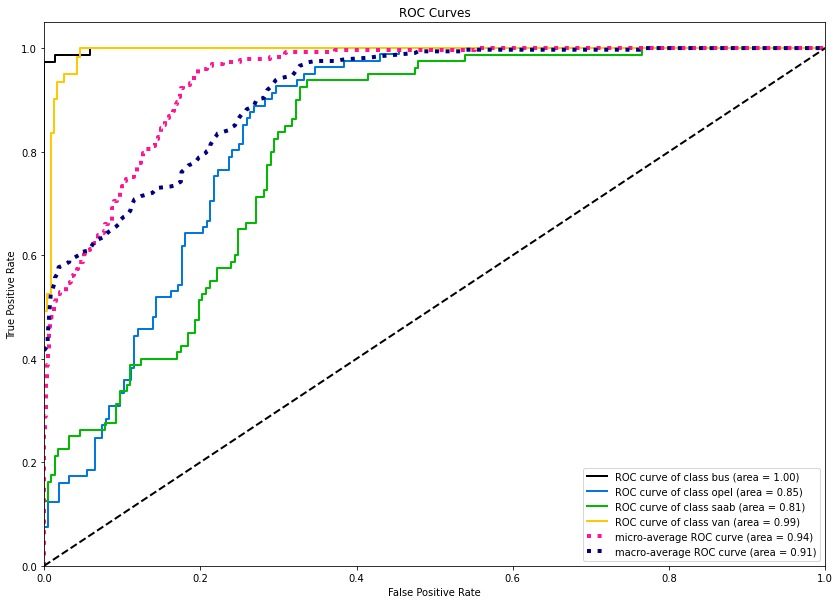

In [77]:
scikitplot.metrics.plot_roc(y_test, rf_cv.predict_proba(X_test), 
                            figsize=(14, 10))

In [ ]:
print("Accuracy score: ", rf.best_score_)